# MARP Results

This notebook reproduces the results of the "MARP" chapter of the manuscript.

In [3]:
# Load the necessary libraries

%load_ext autoreload
%autoreload 2

from marp.mapping import core
from marp.mapping import packer_utils as pu
import onnx
from onnx import numpy_helper as nphelp
import numpy as np
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import onnxruntime as ort
from onnx import helper
import marp.onnx_tools.onnx_utils as onnx_utils
import pandas as pd
import marp.onnx_tools.onnx_splitter as onnx_splitter
import rectpack
import tqdm
import seaborn as sns
from marp.compile import compile

df = pd.DataFrame

def get_packer_string(df_row):
    if df_row['Naive']:
        return 'Naive'
    
    df_row['Offline'] = 'OFF' if df_row['Offline'] else 'ON'
    df_row['SortAlgo'] = '' if df_row['SortAlgo'] == 'SORT_NONE' else df_row['SortAlgo']
    df_row['PackAlgo'] = 'MR' if df_row['PackAlgo'] == 'MaxRectsBssf' else 'SKY'

    return f"{df_row['Offline']}_{df_row['BinAlgo']}_{df_row['PackAlgo']}{df_row['SortAlgo']}"

def get_model_name(df_row):
    return df_row['modelpath'].split('/')[-1].split('.')[0]

## Generate Split Models

Here we generate the split (not necessarily tiled) versions of the ONNX models.
We do this so that the largest layer-equivalent matrices fit in the AIMC core.

To change the core sizes, you can change `C_max` (for the AIMC core rows) and `K_max` (for the AIMC core columns).

These ONNX models are placed into `hwacc_design_garage/onnx_models/*_split.onnx`

This is only done for reference so that we can view them in Netron. For example, [use Netron to inspect the split mbv2 model here](https://netron.app/?url=https://github.com/Lawrence-lugs/hwacc_design_garage/blob/main/onnx_models/mbv2_cifar10_int8_split.onnx).

In [ ]:
modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]
for modelpath in modelpaths:
    nx_model = onnx.load(modelpath)
    onnx_splitter.split_model_to_per_channel(
        nx_model.graph,
        C_max = 256,
        K_max = 256,
        dwC_max= 32)
    onnx.save_model(nx_model, modelpath.replace('.onnx', '_split.onnx'))

## Sample MARP Usage

Here's an example of MARP usage.

Here, we don't need to use a pre-split model because `core.NxModelMapping` already takes `core_size` as an argument and it performs the splits internally.


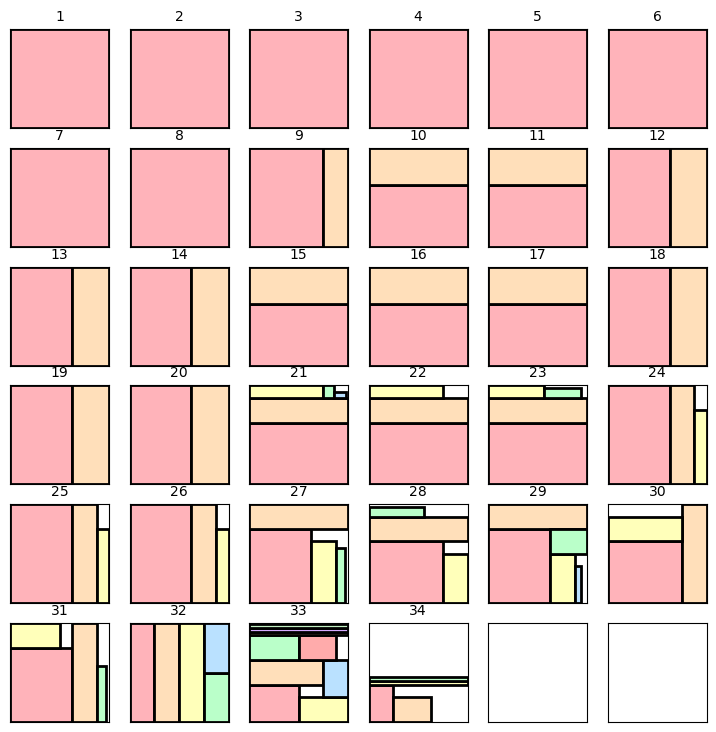

In [2]:
# Define onnx model path
modelpath = 'onnx_models/mbv2_cifar10_int8.onnx'

# Define the packer to use from rectpack
# If packer isn't specified, it will use the Dense packer (MaxRectsBssf with BFF Offline) which is the one here.
packer = rectpack.newPacker(
    mode=rectpack.PackingMode.Offline,
    bin_algo=rectpack.PackingBin.BFF, 
    rotation=False, 
    pack_algo=rectpack.MaxRectsBssf
)

core_size = (256, 256)

nx_model = onnx.load(modelpath)
u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer, naive=False)
u_marped.plot()

## Compilation Sample

Warning! MARP Mapping is fast, but compilation is slow for large models (since we currently compile to text instead of binary by default for debugging).

In [5]:
# Define onnx model path
modelpath = 'onnx_models/ad_quantized_int8.onnx'

# Define the packer to use from rectpack
# If packer isn't specified, it will use the Dense packer (MaxRectsBssf with BFF Offline) which is the one here.
packer = rectpack.newPacker(
    mode=rectpack.PackingMode.Offline,
    bin_algo=rectpack.PackingBin.BFF, 
    rotation=False, 
    pack_algo=rectpack.MaxRectsBssf
)

core_size = (256, 256)

nx_model = onnx.load(modelpath)

input_name = nx_model.graph.input[0].name
input_shape = [d.dim_value for d in nx_model.graph.input[0].type.tensor_type.shape.dim]

# If batch size > 1, set to 1
if input_shape[0] > 1:
    nx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = 1
    input_shape[0] = 1

np.random.seed(0)
input_dict = {
    input_name: np.random.rand(*input_shape).astype(np.float32)
}

compile.traverse_and_compile_nx_graph(
    nx_model      = nx_model,
    input_dict    = input_dict,
    imc_core_size = core_size,
    dwc_core_size = 32,
    packer        = packer
)

Skipping onnx::Gemm_0_/encoder/encoder.0/encoder.0.0/Gemm_MatMul_QuantizeLinear as it is not compilable...
Skipping split_matmul_0_a_slice_0_0 as it is not compilable...
Skipping split_matmul_0_a_slice_0_1 as it is not compilable...
Skipping split_matmul_0_a_slice_0_2 as it is not compilable...
============ Compiling Node ============
Compiling split_matmul_0_qmatmul_0_0 as first node of set...
split_matmul_0_qmatmul_0_0 is followed by a non-compilable node, so it will write the ofmap to external memory.
Rewriting bin split_matmul_0_qmatmul_0_0 as bin changed from None to 0...
============ Compiling Node ============
Compiling split_matmul_0_qmatmul_0_1 as first node of set...
split_matmul_0_qmatmul_0_1 is followed by a non-compilable node, so it will write the ofmap to external memory.
NODE split_matmul_0_qmatmul_0_1 (id=5) BIN COMBO!!! Reusing bin 0.
============ Compiling Node ============
Compiling split_matmul_0_qmatmul_0_2 as first node of set...
split_matmul_0_qmatmul_0_2 is fol

/home/laquizon/lawrence-workspace/hwacc_design_garage/marp/compile/stimulus_gen.py:266: RuntimeWarning: invalid value encountered in log
  adc_ref_range_shifts = np.ceil(np.log(mean_partial)/np.log(2)) - 3


Skipping /encoder/encoder.4/encoder.4.0/Gemm_Add_quant as it is not compilable...
Skipping /encoder/encoder.4/encoder.4.0/Gemm_output_0_/encoder/encoder.4/encoder.4.0/Gemm_Add_DequantizeLinear as it is not compilable...
Skipping /encoder/encoder.4/encoder.4.1/BatchNormalization as it is not compilable...
Skipping /encoder/encoder.4/encoder.4.2/Relu as it is not compilable...
Skipping /encoder/encoder.4/encoder.4.2/Relu_output_0_/decoder/decoder.0/decoder.0.0/Gemm_MatMul_QuantizeLinear as it is not compilable...
============ Compiling Node ============
Compiling split_matmul_5_qmatmul_0_0 as first node of set...
split_matmul_5_qmatmul_0_0 is followed by a non-compilable node, so it will write the ofmap to external memory.
NODE split_matmul_5_qmatmul_0_0 (id=38) BIN COMBO!!! Reusing bin 4.
Skipping /decoder/decoder.0/decoder.0.0/Gemm_Add_quant as it is not compilable...
Skipping /decoder/decoder.0/decoder.0.0/Gemm_output_0_/decoder/decoder.0/decoder.0.0/Gemm_Add_DequantizeLinear as it is

['INFO',
 'split_matmul_0_qmatmul_0_0',
 'Current loaded ifmap: None',
 'NODE split_matmul_0_qmatmul_0_0 (id=4) reading ifmap (split_matmul_0_a_0_0) from external memory',
 'NODE split_matmul_0_qmatmul_0_0 (id=4) will write ofmap (split_matmul_0_out_0_0) into external memory',
 'NODE split_matmul_0_qmatmul_0_0 (id=4) will rewrite the bin from None to 0',
 'ENDINFO',
 'LOAD 00000011 88111153',
 'LOAD 00000012 00010001',
 'LOAD 00000013 00010001',
 'LOAD 00000014 00800100',
 'LOAD 00000015 00000000',
 'LOAD 00000016 00000000',
 'LOAD 00000010 00000002',
 'LOAD 00000100 13b52a13',
 'LOAD 00000100 84e616f5',
 'LOAD 00000100 a2369660',
 'LOAD 00000100 0e7b871a',
 'LOAD 00000100 46b2acf0',
 'LOAD 00000100 ec3a6e1a',
 'LOAD 00000100 e8e3c6ee',
 'LOAD 00000100 2459630d',
 'LOAD 00000100 236a5e79',
 'LOAD 00000100 772e0d58',
 'LOAD 00000100 4412c42d',
 'LOAD 00000100 d02457dd',
 'LOAD 00000100 6fc6b0d1',
 'LOAD 00000100 8107560a',
 'LOAD 00000100 92a4cb79',
 'LOAD 00000100 0c8cbe3d',
 'LOAD 000

## Results: MARP experients on MBv2

In the next 2 cells, we perform the experiments on MBv2 where we found the Dense, Balanced, and WriteOptimized packers. 

In [ ]:
# Setup sweeps for packing experiments


modes = [
    'ON','OFF'
]

modes_dict = {
    'ON': rectpack.PackingMode.Online,
    'OFF': rectpack.PackingMode.Offline
}

bin_heuristic = [
    'BBF','BNF','BFF'
]

bin_heuristic_dict = {
    'BBF': rectpack.PackingBin.BBF,
    'BNF': rectpack.PackingBin.BNF,
    'BFF': rectpack.PackingBin.BFF
}

fit_heuristic = [
    'BAF','BL','BSSF'
]

fit_heuristic_dict = {
    'BAF': rectpack.MaxRectsBaf,
    'BL': rectpack.MaxRectsBl, 
    'BSSF': rectpack.MaxRectsBssf
}

sort_order = [
    'SO', 'SS', 'SF'
]

sort_order_dict = {
    'SO': rectpack.SORT_NONE,
    'SS': rectpack.SORT_SSIDE,
    'SF': rectpack.SORT_PERI
}

core_size = (256, 256)


modelpath = 'onnx_models/mbv2_cifar10_int8.onnx'


results_df = pd.DataFrame(columns=[
    'Mode', 'Bin Heuristic', 'Fit Heuristic', 'Sort Order','Nwrites','Nbins'
])

for mode in modes:
    for bin_algo in bin_heuristic:
        for pack_algo in fit_heuristic:
            for sort_algo in sort_order:
                try:
                    packer = rectpack.newPacker(
                        mode=modes_dict[mode],
                        bin_algo=bin_heuristic_dict[bin_algo], 
                        rotation=False, 
                        pack_algo=fit_heuristic_dict[pack_algo],
                        sort_algo=sort_order_dict[sort_algo]
                    )
                except:
                    print(f"Skipping {modelpath} with bin_algo={bin_algo}, pack_algo={pack_algo}, sort_algo={sort_algo}")
                    continue
                u_marped = core.NxModelMapping(
                    onnx.load(modelpath),
                    imc_core_size=core_size,
                    packer=packer,
                    naive=False
                )
                u_qracc = core.QRAccModel(
                    u_marped,
                    num_cores=1
                )
                results_df.loc[len(results_df)] = {
                    'Mode': mode,
                    'Bin Heuristic': bin_algo,
                    'Fit Heuristic': pack_algo,
                    'Sort Order': sort_algo,
                    'Nwrites': u_qracc.weight_bin_writes,
                    'Nbins': u_qracc.total_bins
                }

results_df


In [ ]:
sns.set_theme(style="whitegrid")

# fig,ax = plt.subplots(1,2,figsize=(5, 3), dpi=300)

# OFF must be on the left
results_df['Mode'] = pd.Categorical(results_df['Mode'], categories=['OFF', 'ON'], ordered=True)

facetgrid = sns.relplot(
    data=results_df,
    x='Nbins',
    y='Nwrites',
    hue='Bin Heuristic',
    col='Mode',
    style='Fit Heuristic',
    size='Sort Order',
    sizes=(50,150)
)

# Add new datapoint called Conventional Mapping at 91, 92 with a red star
for ax in facetgrid.axes.flat:
    ax.scatter(91, 92, color='red', marker='*', s=150, label='Conventional Mapping', zorder=10)

# Get the legend from the facet grid and add Conventional Mapping
if facetgrid._legend is not None:
    # Get existing legend handles and labels
    handles, labels = facetgrid._legend.legendHandles, [t.get_text() for t in facetgrid._legend.get_texts()]
    
    # Add Conventional Mapping if not present
    if 'Conventional Mapping' not in labels:
        handles.append(plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=10))
        labels.append('Conventional Mapping')
    
    # Update the legend
    facetgrid._legend.remove()
    facetgrid._legend = facetgrid.fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.01, 1), 
                                           fontsize='x-small', frameon=False)

# set legend outside
facetgrid._legend.set_bbox_to_anchor((1.01, 1))
facetgrid._legend.set_loc('upper left')

# set figsize to 5,3 dpi to 300
facetgrid.fig.set_size_inches(5, 3)
facetgrid.set_axis_labels('$N_{bins}$', '$N_{writes}$')
facetgrid.fig.set_dpi(300)

plt.tight_layout()

## Experiments with MLPerfTiny

Next, here are the experiments with the 4 MLPerfTiny models also with varying rectpack hyperparameters.

In [ ]:
# Setup sweeps for packing experiments

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packer_argument_headers = [
    'Naive','Offline','BinAlgo','PackAlgo','SortAlgo'
]
get_packer_arguments = [
    [True,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,True,'BFF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BBF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BNF','MaxRectsBssf','SORT_NONE'],
    [False,False,'BFF','MaxRectsBssf','SORT_NONE'],
]
core_sizes = [(256,256),(512,512)]

In [ ]:
results = []
with tqdm.tqdm(total=len(modelpaths) * len(core_sizes) * len(get_packer_arguments), desc="Total Progress") as pbar:
    for modelpath in modelpaths:
        for core_size in core_sizes:
            for args in get_packer_arguments:
                packer = pu.get_packer(*args, core_size=core_size)
                nx_model = onnx.load(modelpath)
                u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer)

                if not u_marped.success:
                    print(f"Packing failed for {modelpath} with core size {core_size} and arguments {args}")
                    pbar.update(1)
                    continue

                u_qracc = core.QRAccModel(packed_cgraph=u_marped, num_cores=1)
                results.append({
                    'modelpath': modelpath,
                    'core_size': core_size,
                    'utilization': u_qracc.utilization,
                    'bin_writes': u_qracc.weight_bin_writes,
                    'nbins': u_marped.nbins,
                    **dict(zip(packer_argument_headers, args))
                })
                pbar.update(1)

df = pd.DataFrame(results)
df['PackerArgs'] = df.apply(get_packer_string, axis=1)
df['ModelName'] = df.apply(get_model_name, axis=1)
df.drop(columns=packer_argument_headers, inplace=True)
df.drop(columns=['modelpath'], inplace=True)

In [ ]:
sns.set_theme(style="whitegrid")
# Create a new column for marker and color
df['Marker'] = df['PackerArgs'].apply(lambda x: '*' if x == 'Naive' else 'o')
df['Color'] = df['PackerArgs'].apply(lambda x: 'red' if x == 'Naive' else None)

df = df[df['core_size'] == (256, 256)]

marker_dict = {
    'Naive': '*',
    'ON_BBF_MR': 'o',
    'OFF_BBF_MR': 'o',
    'ON_BFF_MR': 'o',
    'OFF_BNF_MR': 'o',
    'ON_BNF_MR': 'o',
    'OFF_BFF_MR': 'o'
}

sizes_dict = {
    'Naive': 300,
    'ON_BBF_MR': 100,
    'OFF_BBF_MR': 100,
    'ON_BFF_MR': 100,
    'OFF_BNF_MR': 100,
    'ON_BNF_MR': 100,
    'OFF_BFF_MR': 100
}

# Create a color palette based on viridis, but set 'Naive' to red
viridis_palette = sns.color_palette("viridis", n_colors=len(marker_dict) - 1)
custom_palette = {'Naive': 'red'}
for k, c in zip([k for k in marker_dict if k != 'Naive'], viridis_palette):
    custom_palette[k] = c

# Plot with custom markers and colors
g = sns.relplot(
    data=df,
    x='bin_writes',
    y='utilization',
    col='ModelName',
    row='core_size',
    hue='PackerArgs',
    kind='scatter',
    palette=custom_palette,
    facet_kws={'sharey': True, 'sharex': False},
    size='PackerArgs',
    sizes=sizes_dict,  # use sizes_dict to set marker sizes
    style='PackerArgs',  # use style to distinguish 'Naive'
    markers=marker_dict
)

# Set red color for 'Naive' points
for ax in g.axes.flat:
    for path_collection, label in zip(ax.collections, g._legend_data.keys()):
        if label == 'Naive':
            path_collection.set_color('red')
g.figure.set_size_inches(8, 2.5)
g.figure.set_dpi(300)
plt.tight_layout()

# set legend outside
g._legend.set_bbox_to_anchor((1.01, 1))
g._legend.set_loc('upper left')
# rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')

title_dict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet',
}

# remove everything before = in the titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title().split('=')[-1].strip())
# set titles
for ax in g.axes.flat:
    ax.set_title(title_dict[ax.get_title()])
# set x labels to 'Bin Writes'
for ax in g.axes.flat:
    ax.set_xlabel('Bin Writes')
# set y labels to 'Utilization'
for ax in g.axes.flat:
    ax.set_ylabel('Utilization')

## Results crunching for the Naive packer

Here, we tabulate the results for the Naive packer

In [ ]:
# Get rows where packer is naive
naive_rows = df[df['core_size'] == (256, 256)]
naive_rows = naive_rows.sort_values(by='utilization', ascending=False)
# Use model name as index and pivot the core size
naive_rows

ModelNameDict = {
    'ad_quantized_int8': 'FC-AE',
    'ks_quantized_int8': 'DS-CNN',
    'mbv2_cifar10_int8': 'MBV2',
    'ic_quantized_int8': 'ResNet'
}
packerArgsDict = {
    'Naive': 'Naive',
    'OFF_BBF_MR': 'Dense',
    'ON_BBF_MR': 'Balanced',
    'ON_BNF_MR': 'WriteOptimized'
}

# Rename the ModelName column
naive_rows['ModelName'] = naive_rows['ModelName'].apply(lambda x: ModelNameDict.get(x, x))
# Rename the PackerArgs column
naive_rows['PackerArgs'] = naive_rows['PackerArgs'].apply(lambda x: packerArgsDict.get(x, x))
# if the PackerArgs is not in the dict, drop it
naive_rows = naive_rows[naive_rows['PackerArgs'].isin(packerArgsDict.values())]
naive_rows = naive_rows.drop(columns=['core_size'])
naive_rows.set_index(['ModelName', 'PackerArgs'], inplace=True)
naive_rows.rename(columns={'bin_writes': 'Bin Writes', 'utilization': 'Utilization', 'nbins' : '# Bins'}, inplace=True)

# Rename indices to  'ModelName':'Model', 'PackerArgs':'Packer'
naive_rows.index.names = ['Model', 'Packer']
# Sort by ModelName and then by PackerArgs

# sort by ModelName and then by utilization
naive_rows = naive_rows.sort_index(level='Model')
# rename the bin writes column

packer_order = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']
naive_rows = naive_rows.reindex(
    pd.MultiIndex.from_product(
        [naive_rows.index.levels[0], packer_order],
        names=naive_rows.index.names
    ),
    fill_value=np.nan
)

naive_rows.to_csv('naive_mlperftiny.csv')
naive_rows

## Plots for the 4 packer types on each model

In [ ]:
# Setup sweeps for packing experiments

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packers = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']


core_size = (256, 256)

for i, modelpath in enumerate(modelpaths):
    for j, packer_name in enumerate(packers):
        nx_model = onnx.load(modelpath)
        packer = get_packer(packer_name)
        u_marped = core.NxModelMapping(nx_model, imc_core_size=core_size, packer=packer)
        if not u_marped.success:
            print(f"Packing failed for {modelpath} with packer {packer_name}")
            continue
        u_marped.plot(name=f"{modelpath.split('/')[-1].split('.')[0]} - {packer_name}")
        ax.set_title(f"{modelpath.split('/')[-1].split('.')[0]} - {packer_name}")

In [7]:
# Try compiling (most) models with all packers
# We avoid compiling MBv2 because that's huge

from marp.compile import compile

modelpaths = [
    'onnx_models/ad_quantized_int8.onnx',
    'onnx_models/ks_quantized_int8.onnx',
    'onnx_models/mbv2_cifar10_int8.onnx',
    'onnx_models/ic_quantized_int8.onnx'
]

packers = ['Naive', 'Dense', 'Balanced', 'WriteOptimized']

core_size = (256, 256)
dwc_core_size = 32

for i, modelpath in enumerate(modelpaths):
    for j, packer_name in enumerate(packers):
        nx_model = onnx.load(modelpath)
        packer = pu.get_packer_by_type(packer_name)

        # Generate a fake input dictionary (used to infer the shape of intermediate tensors)
        input_name = nx_model.graph.input[0].name
        input_shape = [d.dim_value for d in nx_model.graph.input[0].type.tensor_type.shape.dim]
        if input_shape[0] > 1:
            nx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value = 1
            input_shape[0] = 1
        input_dict = {
            input_name: np.random.rand(*input_shape).astype(np.float32)
        }

        commands = compile.traverse_and_compile_nx_graph(
            nx_model      = nx_model,
            input_dict    = input_dict,
            imc_core_size = core_size,
            dwc_core_size = dwc_core_size,
            packer        = packer
        )  


Skipping onnx::Gemm_0_/encoder/encoder.0/encoder.0.0/Gemm_MatMul_QuantizeLinear as it is not compilable...
Skipping split_matmul_0_a_slice_0_0 as it is not compilable...
Skipping split_matmul_0_a_slice_0_1 as it is not compilable...
Skipping split_matmul_0_a_slice_0_2 as it is not compilable...
============ Compiling Node ============
Compiling split_matmul_0_qmatmul_0_0 as first node of set...
split_matmul_0_qmatmul_0_0 is followed by a non-compilable node, so it will write the ofmap to external memory.
Rewriting bin split_matmul_0_qmatmul_0_0 as bin changed from None to 0...
============ Compiling Node ============
Compiling split_matmul_0_qmatmul_0_1 as first node of set...
split_matmul_0_qmatmul_0_1 is followed by a non-compilable node, so it will write the ofmap to external memory.
Rewriting bin split_matmul_0_qmatmul_0_1 as bin changed from 0 to 1...
============ Compiling Node ============
Compiling split_matmul_0_qmatmul_0_2 as first node of set...
split_matmul_0_qmatmul_0_2 is

KeyboardInterrupt: 